<a href="https://colab.research.google.com/github/Ruthnguli/Twitter-Sentiment-Analysis/blob/main/YellowStone_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading packages

In [ ]:
!pip install snscrape

!pip3 install ktrain

!python -m pip install tensorflow_text

!pip install transformers

     |████████████████████████████████| 25.3 MB 50.3 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 981 kB 35.9 MB/s 
     |████████████████████████████████| 263 kB 46.2 MB/s 
     |████████████████████████████████| 2.8 MB 34.0 MB/s 
     |████████████████████████████████| 1.2 MB 36.5 MB/s 
     |████████████████████████████████| 468 kB 37.3 MB/s 
     |████████████████████████████████| 3.3 MB 34.8 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
  Created wheel for ktrain: filename=ktrain-0.30.0-py3-none-any.whl size=25309161 sha256=7e36c070676e0113adc6ea230f7dc25a7df512d330523c93e079101344305dc0
  Stored in directory: /root/.cache/pip/wheels/25/00/ae/80d1b19dd02bc2e6bc9bac32ba7dbaa59aad789e93274e4868
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=811e6ba6

In [ ]:
# Importing Libraries
#
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import ktrain
from ktrain import text
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
import os
import snscrape.modules.twitter as sntwitter
import re, string
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime as dtime
import collections

In [ ]:
#Importing lemmatization libraries
import nltk

from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

## Functions

In [ ]:
#function for sorting the multiple hashes and multiple @
#also sorts out @'s and # that occur within text
# changes lonesome @ to at
def find_the (text):
    while len(re.findall('##' , text)) != 0:
        text = re.sub('##' , '#' ,text)
    while len(re.findall('@@' , text)) != 0:
        text = re.sub('@@' , '@' ,text)

    no_h = len(re.findall('#',text))
    #make sure the @ is changed for at
    no_a = len(re.findall('@',text))
    
    text = re.sub('@(\s|\.|\?|,|;|:|!|\(|\))', 'at' , text)
    text = re.sub('\s' , ' ' , text)
    text = re.sub('\S@' , ' @' , text)
    text = re.sub('\S#' , ' #' , text)

    #while len(re.findall('\s\s' , text)) != 0:
    #    text = re.sub('\s\s' , '\s' ,text)

    #none_repeat = text
    text_a = text.split()

            
    return text



In [ ]:
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()
#stemmer = SnowballStemmer("english")
STOPWORDS.update(['mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will'])# 'rt'
corpus = []
def preprocess_tweet(tweet):
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would",tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    #tweet = re.sub('[^a-zA-Z]',' ',tweet)
    #tweet = re.sub(r'[^\x00-\x7f]','',tweet)
    #tweet = " ".join([stemmer.stem(word) for word in tweet.split()])
    tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if not word in set(STOPWORDS)]
    tweet = ' '.join(tweet)
    return tweet

In [ ]:
# Creating a tag maker function to extract @'s and #'s as the data is cleaned by the lemmatizer so as not to alter the tags
def tag_maker (text):
  text_a = text.split()
  tag_a = []
  for r in range(0, len(text_a)):
    if text_a[r].startswith('#') or text_a[r].startswith('@'):
      tag_name = '<<yellowstone<<' + str(len(tag_a)) + '>>yellowstone>>'
      tag_a.append(text_a[r])
      text_a[r] = tag_name

  r_text = ' '.join(text_a)

  return [r_text , tag_a]

  

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']


In [ ]:
# Creating a tag replacer function replaces tags from text that has been lematized to the original @'s and #'s


def tag_replacer (text , tag_a):
  text_a = text.split()

  for r in range(0, len(text_a)):
    if ('<<yellowstone<<' in text_a[r]) and ('>>yellowstone>>' in text_a[r]):
      num = text_a[r]
      num = num[15:][:-15]
      num = int(num)
      text_a[r] = tag_a[num]

  r_text = ' '.join(text_a)

  return r_text

In [ ]:
# Creating a lema and stem function to call the tag maker the lematizer and the tag replacer

def tags_lema_stem(text):
  for_lem = tag_maker(text)
  for_tag_removal = preprocess_tweet(for_lem[0])
  r_text = tag_replacer(for_tag_removal, for_lem[1])

  return r_text

In [ ]:
# fuction to get the ats and hashes out 

def hash_and_ats (text):
    text_a = text.split()
    hash_list = []
    at_list = []
    
    for a in text_a:
        
        if a.startswith('#'):
            a = a.lower()
            hash_list.append(a)
        elif a.startswith('@'):
            at_list.append(a)

    return [hash_list , at_list]

In [ ]:
# removes words that start with at predefined set of characters in a list
def header_remover(text, hr):
    to_drop = hr
    text_a = text.split()
    for g in range(len(text_a)-1, -1 , -1):
        for a in to_drop:
            if text_a[g].startswith(a):
                text_a.pop(g)
                break

    text = ' '.join(text_a)
    return text

In [ ]:
# Polarity
# Function to get polarity(sentiments) of text using the module textblob
#
def get_polarity(text):
    try:
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [ ]:
# Subjectivity
# Function to get polatiy of text using the module textblob
def get_subjectivity(text):
    try:
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

In [ ]:
# Labelling sentiments to either Positive or Negative
#
def positive_negative(f):
	if f == 0:
		return 'Neutral'
	elif f < 0:
		return 'Negative'
	elif f > 0:
		return 'Positive'

In [ ]:
#Visiualization function
#
def bar_outlier (stat_dataframe, threshold):
  sec = stat_dataframe.iloc[1,1]
  fir = stat_dataframe.iloc[0,1]
  if threshold != 0:
    if fir > (sec * threshold):
      stat_dataframe = stat_dataframe.drop(stat_dataframe.index[0])
      stat_dataframe.reset_index(inplace=True)
      stat_dataframe.drop(columns = ['index'] , inplace = True)
  return stat_dataframe



In [ ]:
#Visiualization function
def make_bars(h_list , entries, f_size, threshold, ord , tra , xl , yl,titl):
  c = collections.Counter(sum(h_list, []))
  hash = pd.DataFrame(c.most_common(entries))
  hash = bar_outlier(hash , threshold)
  if ord == 0:
  	hash = hash.sort_values(1, ascending = False)
  
  hash = hash.head(tra)
  hash = hash.sort_values(1, ascending = True)
  fig = plt.figure(figsize = f_size)
  ax = fig.add_axes([0,0,1,1])
  ax.barh(hash[0],hash[1])
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.title(titl)
  plt.xticks(rotation=60)

  co_names = [yl,xl]
  hash = hash.sort_values(1, ascending = False)
  hash.columns = co_names
  hash.reset_index(inplace = True)
  hash.drop(columns = ['index'], inplace = True)
  return hash

In [ ]:
# creating a def function to identify hastags and ats for visualization
#
def for_pie (a,b):
  if a == [] and b == []:
    return 0
  if a == [] and b != []:
    return 1
  if a != [] and b == []:
    return 2
  if a != [] and b != []:
    return 3

In [ ]:
#Fits data into machine learning models and gives the relevant statistics
#calls on the hyperparameter tuning function

def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    #b_fit = param_tuning(clf, param_grid, training_data, y_train, testing_data, y_test)
    #y_pred = b_fit.predict(x_test)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    conf_matrix(y_test , y_pred , name, ['Positive' , 'Negative'])
    return [accuracy , f1 , pre, rec]

In [ ]:
# A function that does the hyperparameter tuning for the model

def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5,
                           n_jobs= -1)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)

    print('Best parameters:')
    print(grid_fit.best_params_)
    print("Accuracy: ")
    print(accuracy_score(y_test, best_predictions))
    print('F1-score: ')
    print(f1_score(y_test, best_predictions))
    print("Precision: ")
    print(precision_score(y_test, best_predictions))
    print('Recall: ')
    print(recall_score(y_test, best_predictions))

    return best_clf

In [ ]:
# Generates a confusion matrix
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sn.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [ ]:
# Labelling sentiments to either Positive or Negative
#
def positive_negative_b(f):
	if f < 0:
		return 'Negative'
	elif f >= 0:
		return 'Positive'

## Constants

In [ ]:
ENTRIES = 15
F_SIZE = (15,15)
THRESHOLD = 1.5
ORDER = 0
GRAPHING_COUNT = 7

# Business Understanding

Due to the nature of the data collected by twitter; raw customer data can be derived or gotten from twitter directly that befits a search term, a mention or on a given trending topic. This data can be analyzed for sentiment to get the customers reaction to a given product, news or general feedback. Also the frequency of the tweets within a given topic can indicate the customer behavior that will affect the financial trend of the company making the aforementioned product. Moreover; a potential investor can analyze from the sentiment of the end user their polarity towards the company and their respective products which in turn can help in making prudent investment decisions. Another issue that comes about is marketing of products whereby digital marketing using twitter is hard to quantify; a study will be done with the aim to find solutions whereby the targeted audience can efficiently be sought after. Machine learning can be used to find the reaction of a given tweet. Our research will scrape information on areas to be used to advise the user on the best areas to follow.


# DATA UNDERSTANDING

Data in twitter occurs through its users composing and sending a tweet. That tweet may have media attached, a link, or another tweet. Some of the data that occurs in twitter are retweets which are basically users tweeting another users tweet; this tweets will have the original users twitter handle and the number of retweets that said tweet has. Another metric within twitter is the number of likes which is user generated by other users ‘liking’ said tweet. Tweets can also be quoted; this is a feature that was added onto the platform. 


In [ ]:
start_scrape = False

## Data Acquisition

## Loading of data aquired before

In [ ]:
file_list = os.listdir()
file_lname = 0
for a in file_list:
  if 'tweet' in a:
    file_lname = a

In [ ]:
print(file_lname)

tweets 2022-04-21 02_11_54.491834


In [ ]:
try :
  pd.read_csv(file_lname)
except:
  start_scrape = True
  print('Scrapping will be done')
else:
  print ('Loading from file')
  tweets_df2 = pd.read_csv(file_lname)

Loading from file


## Scraping

In [ ]:
if start_scrape == True:
  # Creating list to append tweet data to
  tweets_list2 = []

  # Using TwitterSearchScraper to scrape data and append tweets to list
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper('EABL').get_items()):
      if i>5000:
          break
      tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.username])
      
  # Creating a dataframe from the tweets list above
  tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Tweet', 'Username'])
  file_name = 'tweets '+ str(dtime.now())
  tweets_df2.to_csv(file_name, index = False)

## Previewing the data

In [ ]:
# Previewing the top 20 of data
#
tweets_df2.head(20)

,Datetime,Tweet Id,Tweet,Username
0,2022-04-20 20:02:56+00:00,1516870050191392775,@CNairobian1 EABL hizo mitungi si mzidrop off ...,molly5_manuel
1,2022-04-20 19:42:44+00:00,1516864964472053763,@EABL_PLC Once again please ask Israel in hr t...,pwsmith03
2,2022-04-20 13:45:23+00:00,1516775033720422413,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,loffi_ruskins
3,2022-04-20 13:21:25+00:00,1516769002307178500,@mmnjug @Kenyans I rember him from the EABL fi...,theink_junkyard
4,2022-04-20 12:25:00+00:00,1516754808010592264,@saitot_i @EABL_PLC Tell them about me,2njer_i
5,2022-04-20 12:24:08+00:00,1516754589713903624,@2njer_i @EABL_PLC Tusker hupeana free,saitot_i
6,2022-04-20 12:12:42+00:00,1516751712777916423,Weh! I’m running low on stock.. time to hit @E...,2njer_i
7,2022-04-20 11:38:59+00:00,1516743226379616259,@MenigoMenthoya Connect job apo eabl,informerQ
8,2022-04-20 11:00:02+00:00,1516733423838273539,#LIVMUN #Shahbal #NSEKenya\n\nHourly Top Perfo...,MainaKa62578060
9,2022-04-20 10:45:27+00:00,1516729756024446983,@MenigoMenthoya Been dying kufanya wera hapa @...,mkulima_MJ


In [ ]:
# Preview the shape of data
#
tweets_df2.shape

(5001, 4)

In [ ]:
# preview of 20 random samples
#
tweets_df2.sample(10)

,Datetime,Tweet Id,Tweet,Username
1718,2022-02-28 06:49:27+00:00,1498188582481182723,Looking forward to speaking with the next gene...,graham_vt
3046,2022-01-04 12:28:06+00:00,1478342474204692483,The UBS Tusker is awful..\n #EABL @EABL_PLC ht...,Bgeffa
1294,2022-03-05 04:51:12+00:00,1499970762261860353,Start your Weekend with a great massage servic...,Eve_lynKE
3583,2021-12-16 08:08:27+00:00,1471391759435456523,@ThisIsAllexie @ntvkenya U only saw EABL in th...,noelanyango809
3581,2021-12-16 10:47:42+00:00,1471431837796995080,@graham_vt @EABL_PLC @thedigitaldiva @OgilvyAf...,KennethOgwang
4850,2021-10-23 18:45:22+00:00,1451983100683096067,@Polycarpboss @sampao_p Are you trying to say ...,NdegeKev
4683,2021-10-29 15:15:06+00:00,1454104512541741056,CAN THE @EABL_PLC urgently respond to this? An...,Cofek_Africa
4959,2021-10-20 08:58:56+00:00,1450748356939112450,@Jabali_Jr @Gilbeys @eabl told you those flavo...,_UncleKen
2117,2022-02-07 13:34:46+00:00,1490680437500485632,@bevalynekwambo3 @EABL_PLC,KariukiKawira
1108,2022-03-06 07:19:13+00:00,1500370401112821762,Shock as a Guy Drives His Female Employer to a...,ViralKenyan


# DATA PREPARATION

## Cleaning Data

In [ ]:
# dropping irrelevant columns
df = tweets_df2.drop(['Datetime', 'Tweet Id', 'Username'], axis = 1) 

# renaming column 
df.columns = ['tweet']

# previewing datset
df.sample(5)

,tweet
4629,@moneyacademyKE Everyone is now learning from ...
1659,It's EABL game day. Let's go!\n\n➡️ https://t....
704,@Gitz__ Hi @EABL_PLC
2494,EABL Group net profit grows 131pc to Shs8.7bn ...
1295,@NjorogeMuchiri @KenyaBreweries It needs a lot...


In [ ]:
# getting non repetitive column
# handling whitespaces
df['nr_tweet'] = df.tweet.apply(lambda d: find_the(d))
df.head()

,tweet,nr_tweet
0,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@CNairobian1 EABL hizo mitungi si mzidrop off ...
1,@EABL_PLC Once again please ask Israel in hr t...,@EABL_PLC Once again please ask Israel in hr t...
2,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...
3,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @Kenyans I rember him from the EABL fi...
4,@saitot_i @EABL_PLC Tell them about me,@saitot_i @EABL_PLC Tell them about me


In [ ]:
# We take the non repetitive tweets and change them to lower case, expose them to the tags_lema_stem 
# as well as, removing the (not so sure) while still maintaining the hashtags and ats



df['c_tweet'] = df['nr_tweet'].str.lower()

df['c_tweet'] = df['c_tweet'].apply (lambda i : tags_lema_stem(i))

df['c_tweet'] = df['c_tweet'].apply(lambda i : re.sub('[^a-zA-Z0-9_#@ ]','',i)) #maintains the hashtags and the @'s

df.head(20)

,tweet,nr_tweet,c_tweet
0,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@cnairobian1 eabl hizo mitungi si mzidrop na c...
1,@EABL_PLC Once again please ask Israel in hr t...,@EABL_PLC Once again please ask Israel in hr t...,@eabl_plc please ask israel hr give u feedback...
2,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@amaragibs @oleitumbi hio cover iko kwa meza n...
3,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @kenyans rember eabl fiasco
4,@saitot_i @EABL_PLC Tell them about me,@saitot_i @EABL_PLC Tell them about me,@saitot_i @eabl_plc tell
5,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @eabl_plc tusker hupeana free
6,Weh! I’m running low on stock.. time to hit @E...,Weh! I’m running low on stock.. time to hit @E...,weh im running low stock time hit @eabl_plc re...
7,@MenigoMenthoya Connect job apo eabl,@MenigoMenthoya Connect job apo eabl,@menigomenthoya connect job apo eabl
8,#LIVMUN #Shahbal #NSEKenya\n\nHourly Top Perfo...,#LIVMUN #Shahbal #NSEKenya Hourly Top Perform...,#livmun #shahbal #nsekenya hourly top performe...
9,@MenigoMenthoya Been dying kufanya wera hapa @...,@MenigoMenthoya Been dying kufanya wera hapa @...,@menigomenthoya dying kufanya wera hapa @eabl_...


In [ ]:
# getting the hashtag and ats columns
#
df['hashtags'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[0])
df['ats'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[1])

# preview of random 20 
#
df.sample(2)

,tweet,nr_tweet,c_tweet,hashtags,ats
3079,"In 2022 ; Fuliza , pombe , KFC , love and Sup...","In 2022 ; Fuliza , pombe , KFC , love and Sup...",2022 fuliza pombe kfc love support man eab...,[],[]
2151,@samthaimush @r_taleria @kababakatana 🤣🤣🤣🤣🤣\nJ...,@samthaimush @r_taleria @kababakatana 🤣🤣🤣🤣🤣 Ja...,@samthaimush @r_taleria @kababakatana jana ni...,[],"[@samthaimush, @r_taleria, @kababakatana]"


In [ ]:
# Removing the hash and Ats

df['m_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#' , '@']))
df['h_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['@']))
df['a_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#']))

In [ ]:
# the rest of the stats
df['no_of_punctuations'] = df.tweet.apply(lambda x : len(re.findall('[^a-zA-Z0-9_ ]', x)))
df['no_of_at'] = df['ats'].apply ( lambda s : len(s))
df['no_of_hashes'] = df['ats'].apply ( lambda s : len(s))
df['no_of_words'] = df['nr_tweet'].apply ( lambda s : len(s.split()))

# no of words without @
df['no_of_words_no_at'] = df['no_of_words'] - df['no_of_at']

# no of words without #
df['no_of_words_no_hash'] = df['no_of_words'] - df['no_of_hashes']

# no of words without @ and #
df['no_of_words_no_at_hash'] = df['no_of_words'] - df['no_of_at'] - df['no_of_hashes']
df['length_of_tweet'] = df['nr_tweet'].apply (lambda y : len(y))


In [ ]:
# Viewing our current dataset

df.head(20)

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet
0,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,[],[@CNairobian1],eabl hizo mitungi si mzidrop na convoy flani y...,eabl hizo mitungi si mzidrop na convoy flani y...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,3,1,1,13,12,12,11,75
1,@EABL_PLC Once again please ask Israel in hr t...,@EABL_PLC Once again please ask Israel in hr t...,@eabl_plc please ask israel hr give u feedback...,[],[@EABL_PLC],please ask israel hr give u feedback father la...,please ask israel hr give u feedback father la...,@eabl_plc please ask israel hr give u feedback...,3,1,1,17,16,16,15,94
2,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@amaragibs @oleitumbi hio cover iko kwa meza n...,[],"[@Amaragibs, @OleItumbi]",hio cover iko kwa meza ni zile za keg hupeanwa...,hio cover iko kwa meza ni zile za keg hupeanwa...,@amaragibs @oleitumbi hio cover iko kwa meza n...,3,2,2,14,12,12,10,77
3,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @kenyans rember eabl fiasco,[],"[@mmnjug, @Kenyans]",rember eabl fiasco,rember eabl fiasco,@mmnjug @kenyans rember eabl fiasco,5,2,2,10,8,8,6,53
4,@saitot_i @EABL_PLC Tell them about me,@saitot_i @EABL_PLC Tell them about me,@saitot_i @eabl_plc tell,[],"[@saitot_i, @EABL_PLC]",tell,tell,@saitot_i @eabl_plc tell,2,2,2,6,4,4,2,38
5,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @eabl_plc tusker hupeana free,[],"[@2njer_i, @EABL_PLC]",tusker hupeana free,tusker hupeana free,@2njer_i @eabl_plc tusker hupeana free,2,2,2,5,3,3,1,38
6,Weh! I’m running low on stock.. time to hit @E...,Weh! I’m running low on stock.. time to hit @E...,weh im running low stock time hit @eabl_plc re...,[],[@EABL_PLC],weh im running low stock time hit restock na m...,weh im running low stock time hit restock na m...,weh im running low stock time hit @eabl_plc re...,6,1,1,18,17,17,16,95
7,@MenigoMenthoya Connect job apo eabl,@MenigoMenthoya Connect job apo eabl,@menigomenthoya connect job apo eabl,[],[@MenigoMenthoya],connect job apo eabl,connect job apo eabl,@menigomenthoya connect job apo eabl,1,1,1,5,4,4,3,36
8,#LIVMUN #Shahbal #NSEKenya\n\nHourly Top Perfo...,#LIVMUN #Shahbal #NSEKenya Hourly Top Perform...,#livmun #shahbal #nsekenya hourly top performe...,"[#livmun, #shahbal, #nsekenya]",[],hourly top performer 158 pm eat market open sa...,#livmun #shahbal #nsekenya hourly top performe...,hourly top performer 158 pm eat market open sa...,64,0,0,49,49,49,49,253
9,@MenigoMenthoya Been dying kufanya wera hapa @...,@MenigoMenthoya Been dying kufanya wera hapa @...,@menigomenthoya dying kufanya wera hapa @eabl_...,[],"[@MenigoMenthoya, @EABL_PLC, @MenigoMenthoya]",dying kufanya wera hapa mr nipee connection pa...,dying kufanya wera hapa mr nipee connection pa...,@menigomenthoya dying kufanya wera hapa @eabl_...,5,3,3,13,10,10,7,103


## Testing for digits

In [ ]:
# contains a list of the beginning of the words that should be dropped
#
header_drop = ['http']

In [ ]:
# Finding the number of digits contained in the tweet
#
df['is_there_digit'] = df['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
# Getting the all the digits that are not 0

m = df[(df['is_there_digit'] != 0)]

In [ ]:
# removing the http from the m

m['m_tweet'] = m['m_tweet'].apply(lambda r : header_remover(r, ['http']))

In [ ]:
m['is_there_digit'] = m['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
m[(m['is_there_digit'] != 0)]

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
8,#LIVMUN #Shahbal #NSEKenya\n\nHourly Top Perfo...,#LIVMUN #Shahbal #NSEKenya Hourly Top Perform...,#livmun #shahbal #nsekenya hourly top performe...,"[#livmun, #shahbal, #nsekenya]",[],hourly top performer 158 pm eat market open sa...,#livmun #shahbal #nsekenya hourly top performe...,hourly top performer 158 pm eat market open sa...,64,0,0,49,49,49,49,253,35
13,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...,[],[@SamNeter],problem provision 1618 ableabl option after he...,problem provision 1618 ableabl option after he...,@samneter problem provision 1618 ableabl optio...,9,1,1,43,42,42,41,237,8
30,Talk about an incredibly lucky second guess 😀\...,Talk about an incredibly lucky second guess 😀 ...,talk incredibly lucky second guess wordle 303...,[],[],talk incredibly lucky second guess wordle 303 26,talk incredibly lucky second guess wordle 303 26,talk incredibly lucky second guess wordle 303 26,17,0,0,13,13,13,13,74,5
41,The 1st of January 2021 marked the first time ...,The 1st of January 2021 marked the first time ...,1st january 2021 marked first time history ken...,[],"[@SafaricomPLC, @EABL_PLC, @BatKenya]",1st january 2021 marked first time history ken...,1st january 2021 marked first time history ken...,1st january 2021 marked first time history ken...,3,3,3,26,23,23,20,156,5
42,@Njogu_32 @Kamau266 @2njer_i Kwa hiyo biz uko ...,@Njogu_32 @Kamau266 @2njer_i Kwa hiyo biz uko ...,@njogu_32 @kamau266 @2njer_i kwa hiyo biz uko ...,[],"[@Njogu_32, @Kamau266, @2njer_i]",kwa hiyo biz uko na 1 picha ya uhunye well dis...,kwa hiyo biz uko na 1 picha ya uhunye well dis...,@njogu_32 @kamau266 @2njer_i kwa hiyo biz uko ...,25,3,3,33,30,30,27,239,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971,East African Breweries Limited's fundamental v...,East African Breweries Limited's fundamental v...,east african brewery limited fundamental valua...,[],[@EABL_PLC],east african brewery limited fundamental valua...,east african brewery limited fundamental valua...,east african brewery limited fundamental valua...,24,1,1,37,36,36,35,300,8
4972,Kama ni #TuskerOktobafest2021 mbona tusker mal...,Kama ni #TuskerOktobafest2021 mbona tusker mal...,kama ni #tuskeroktobafest2021 mbona tusker mal...,[#tuskeroktobafest2021],[@EABL_PLC],kama ni mbona tusker malt tunauziwa 300,kama ni #tuskeroktobafest2021 mbona tusker mal...,kama ni mbona tusker malt tunauziwa 300 @eabl_plc,4,1,1,9,8,8,7,72,3
4978,@EABL_PLC \nMy questions is with regards to th...,@EABL_PLC My questions is with regards to the...,@eabl_plc question regard corporate bond ksh11...,[],[@EABL_PLC],question regard corporate bond ksh11bn raised ...,question regard corporate bond ksh11bn raised ...,@eabl_plc question regard corporate bond ksh11...,7,1,1,40,39,39,38,222,12
4982,@coldtusker @voouma @moneyacademyKE @Kenya_Re ...,@coldtusker @voouma @moneyacademyKE @Kenya_Re ...,@coldtusker @voouma @moneyacademyke @kenya_re ...,[],"[@coldtusker, @voouma, @moneyacademyKE, @Kenya...",dy 34 lookout potential red flag risk work gai...,dy 34 lookout potential red flag risk work gai...,@coldtusker @voouma @moneyacademyke @kenya_re ...,19,4,4,58,54,54,50,324,2


In [ ]:
# Previewing our current dataset

df.head(20)

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,[],[@CNairobian1],eabl hizo mitungi si mzidrop na convoy flani y...,eabl hizo mitungi si mzidrop na convoy flani y...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,3,1,1,13,12,12,11,75,0
1,@EABL_PLC Once again please ask Israel in hr t...,@EABL_PLC Once again please ask Israel in hr t...,@eabl_plc please ask israel hr give u feedback...,[],[@EABL_PLC],please ask israel hr give u feedback father la...,please ask israel hr give u feedback father la...,@eabl_plc please ask israel hr give u feedback...,3,1,1,17,16,16,15,94,0
2,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@amaragibs @oleitumbi hio cover iko kwa meza n...,[],"[@Amaragibs, @OleItumbi]",hio cover iko kwa meza ni zile za keg hupeanwa...,hio cover iko kwa meza ni zile za keg hupeanwa...,@amaragibs @oleitumbi hio cover iko kwa meza n...,3,2,2,14,12,12,10,77,0
3,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @kenyans rember eabl fiasco,[],"[@mmnjug, @Kenyans]",rember eabl fiasco,rember eabl fiasco,@mmnjug @kenyans rember eabl fiasco,5,2,2,10,8,8,6,53,0
4,@saitot_i @EABL_PLC Tell them about me,@saitot_i @EABL_PLC Tell them about me,@saitot_i @eabl_plc tell,[],"[@saitot_i, @EABL_PLC]",tell,tell,@saitot_i @eabl_plc tell,2,2,2,6,4,4,2,38,0
5,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @eabl_plc tusker hupeana free,[],"[@2njer_i, @EABL_PLC]",tusker hupeana free,tusker hupeana free,@2njer_i @eabl_plc tusker hupeana free,2,2,2,5,3,3,1,38,0
6,Weh! I’m running low on stock.. time to hit @E...,Weh! I’m running low on stock.. time to hit @E...,weh im running low stock time hit @eabl_plc re...,[],[@EABL_PLC],weh im running low stock time hit restock na m...,weh im running low stock time hit restock na m...,weh im running low stock time hit @eabl_plc re...,6,1,1,18,17,17,16,95,0
7,@MenigoMenthoya Connect job apo eabl,@MenigoMenthoya Connect job apo eabl,@menigomenthoya connect job apo eabl,[],[@MenigoMenthoya],connect job apo eabl,connect job apo eabl,@menigomenthoya connect job apo eabl,1,1,1,5,4,4,3,36,0
8,#LIVMUN #Shahbal #NSEKenya\n\nHourly Top Perfo...,#LIVMUN #Shahbal #NSEKenya Hourly Top Perform...,#livmun #shahbal #nsekenya hourly top performe...,"[#livmun, #shahbal, #nsekenya]",[],hourly top performer 158 pm eat market open sa...,#livmun #shahbal #nsekenya hourly top performe...,hourly top performer 158 pm eat market open sa...,64,0,0,49,49,49,49,253,38
9,@MenigoMenthoya Been dying kufanya wera hapa @...,@MenigoMenthoya Been dying kufanya wera hapa @...,@menigomenthoya dying kufanya wera hapa @eabl_...,[],"[@MenigoMenthoya, @EABL_PLC, @MenigoMenthoya]",dying kufanya wera hapa mr nipee connection pa...,dying kufanya wera hapa mr nipee connection pa...,@menigomenthoya dying kufanya wera hapa @eabl_...,5,3,3,13,10,10,7,103,0


## Duplicated Data

In [ ]:
#delete the duplicates by dropping them and store the result value to a new variable

df2 = df.drop_duplicates('m_tweet',keep='first') 

df2.head(30)

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,[],[@CNairobian1],eabl hizo mitungi si mzidrop na convoy flani y...,eabl hizo mitungi si mzidrop na convoy flani y...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,3,1,1,13,12,12,11,75,0
1,@EABL_PLC Once again please ask Israel in hr t...,@EABL_PLC Once again please ask Israel in hr t...,@eabl_plc please ask israel hr give u feedback...,[],[@EABL_PLC],please ask israel hr give u feedback father la...,please ask israel hr give u feedback father la...,@eabl_plc please ask israel hr give u feedback...,3,1,1,17,16,16,15,94,0
2,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@amaragibs @oleitumbi hio cover iko kwa meza n...,[],"[@Amaragibs, @OleItumbi]",hio cover iko kwa meza ni zile za keg hupeanwa...,hio cover iko kwa meza ni zile za keg hupeanwa...,@amaragibs @oleitumbi hio cover iko kwa meza n...,3,2,2,14,12,12,10,77,0
3,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @kenyans rember eabl fiasco,[],"[@mmnjug, @Kenyans]",rember eabl fiasco,rember eabl fiasco,@mmnjug @kenyans rember eabl fiasco,5,2,2,10,8,8,6,53,0
4,@saitot_i @EABL_PLC Tell them about me,@saitot_i @EABL_PLC Tell them about me,@saitot_i @eabl_plc tell,[],"[@saitot_i, @EABL_PLC]",tell,tell,@saitot_i @eabl_plc tell,2,2,2,6,4,4,2,38,0
5,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @EABL_PLC Tusker hupeana free,@2njer_i @eabl_plc tusker hupeana free,[],"[@2njer_i, @EABL_PLC]",tusker hupeana free,tusker hupeana free,@2njer_i @eabl_plc tusker hupeana free,2,2,2,5,3,3,1,38,0
6,Weh! I’m running low on stock.. time to hit @E...,Weh! I’m running low on stock.. time to hit @E...,weh im running low stock time hit @eabl_plc re...,[],[@EABL_PLC],weh im running low stock time hit restock na m...,weh im running low stock time hit restock na m...,weh im running low stock time hit @eabl_plc re...,6,1,1,18,17,17,16,95,0
7,@MenigoMenthoya Connect job apo eabl,@MenigoMenthoya Connect job apo eabl,@menigomenthoya connect job apo eabl,[],[@MenigoMenthoya],connect job apo eabl,connect job apo eabl,@menigomenthoya connect job apo eabl,1,1,1,5,4,4,3,36,0
8,#LIVMUN #Shahbal #NSEKenya\n\nHourly Top Perfo...,#LIVMUN #Shahbal #NSEKenya Hourly Top Perform...,#livmun #shahbal #nsekenya hourly top performe...,"[#livmun, #shahbal, #nsekenya]",[],hourly top performer 158 pm eat market open sa...,#livmun #shahbal #nsekenya hourly top performe...,hourly top performer 158 pm eat market open sa...,64,0,0,49,49,49,49,253,38
9,@MenigoMenthoya Been dying kufanya wera hapa @...,@MenigoMenthoya Been dying kufanya wera hapa @...,@menigomenthoya dying kufanya wera hapa @eabl_...,[],"[@MenigoMenthoya, @EABL_PLC, @MenigoMenthoya]",dying kufanya wera hapa mr nipee connection pa...,dying kufanya wera hapa mr nipee connection pa...,@menigomenthoya dying kufanya wera hapa @eabl_...,5,3,3,13,10,10,7,103,0


In [ ]:
# we dropped duplicated rows

print(df.shape)
print(df2.shape)

(5001, 17)
(4640, 17)


In [ ]:
# checking white space
print(df2.m_tweet.str.isspace())

print('\n')
print('Number of spaces', df2.m_tweet.str.isspace().sum())

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4997    False
4998    False
4999    False
5000    False
Name: m_tweet, Length: 4640, dtype: bool


Number of spaces 0


In [ ]:
# getting data without whitespaces

df_clean = df2[df2['m_tweet'] != '']
df_clean.head()

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,[],[@CNairobian1],eabl hizo mitungi si mzidrop na convoy flani y...,eabl hizo mitungi si mzidrop na convoy flani y...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,3,1,1,13,12,12,11,75,0
1,@EABL_PLC Once again please ask Israel in hr t...,@EABL_PLC Once again please ask Israel in hr t...,@eabl_plc please ask israel hr give u feedback...,[],[@EABL_PLC],please ask israel hr give u feedback father la...,please ask israel hr give u feedback father la...,@eabl_plc please ask israel hr give u feedback...,3,1,1,17,16,16,15,94,0
2,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@amaragibs @oleitumbi hio cover iko kwa meza n...,[],"[@Amaragibs, @OleItumbi]",hio cover iko kwa meza ni zile za keg hupeanwa...,hio cover iko kwa meza ni zile za keg hupeanwa...,@amaragibs @oleitumbi hio cover iko kwa meza n...,3,2,2,14,12,12,10,77,0
3,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @kenyans rember eabl fiasco,[],"[@mmnjug, @Kenyans]",rember eabl fiasco,rember eabl fiasco,@mmnjug @kenyans rember eabl fiasco,5,2,2,10,8,8,6,53,0
4,@saitot_i @EABL_PLC Tell them about me,@saitot_i @EABL_PLC Tell them about me,@saitot_i @eabl_plc tell,[],"[@saitot_i, @EABL_PLC]",tell,tell,@saitot_i @eabl_plc tell,2,2,2,6,4,4,2,38,0


## Feature Engineering

In [ ]:
# Finally, we will transform the data into occurrences, 
# which will be the features that we will feed into our model
# 

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
counts_cv = count_vectorizer.fit_transform(df_clean['m_tweet'])  
counts_cv

<4639x56032 sparse matrix of type '<class 'numpy.int64'>'
	with 107289 stored elements in Compressed Sparse Row format>

In [ ]:
# We could leave it as the simple word-count per message, but it is better to use Term Frequency Inverse Document Frequency, more known as tf-idf
# 
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts_cv)

counts_tfid = transformer.transform(counts_cv)

# EXPLORATORY DATA ANALYSIS

## Visualizations

### Hashtags

In [ ]:
# Visualizing most commonly used hashtags
#
h_df = df_clean['hashtags'].apply(lambda f : ' '.join(f))

make_bars(df_clean['ats'].to_list(), ENTRIES , F_SIZE, THRESHOLD, ORDER, GRAPHING_COUNTRESHOLD, ORDER, GRAPHING_COUNT,"count","Mentions")

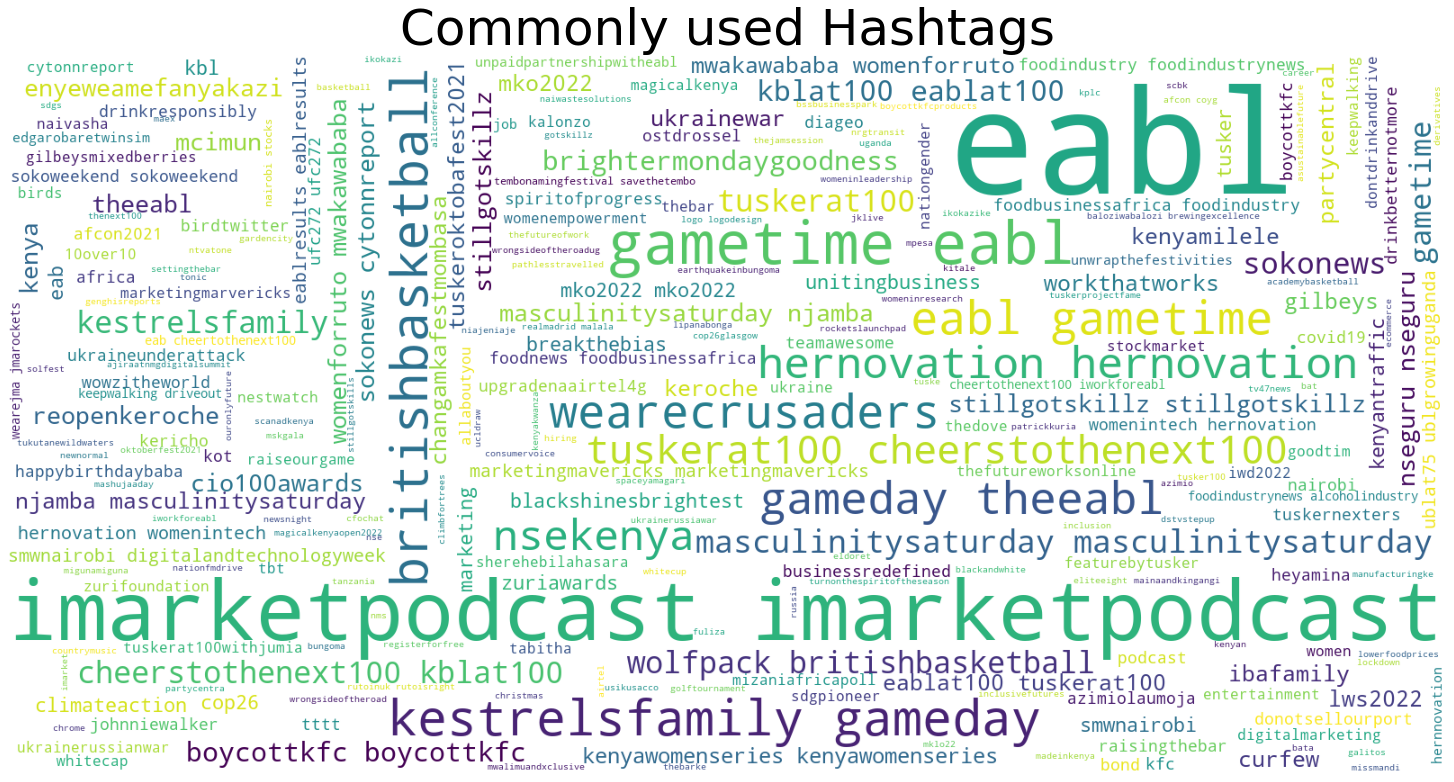

In [ ]:
# Mostly used hashtags in a word cloud
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="#ffffff").generate(" ".join(h_df))
plt.imshow(wc2)
plt.axis('off')
plt.title('Commonly used Hashtags', fontsize=50)
plt.tight_layout(pad=0)
plt.show()



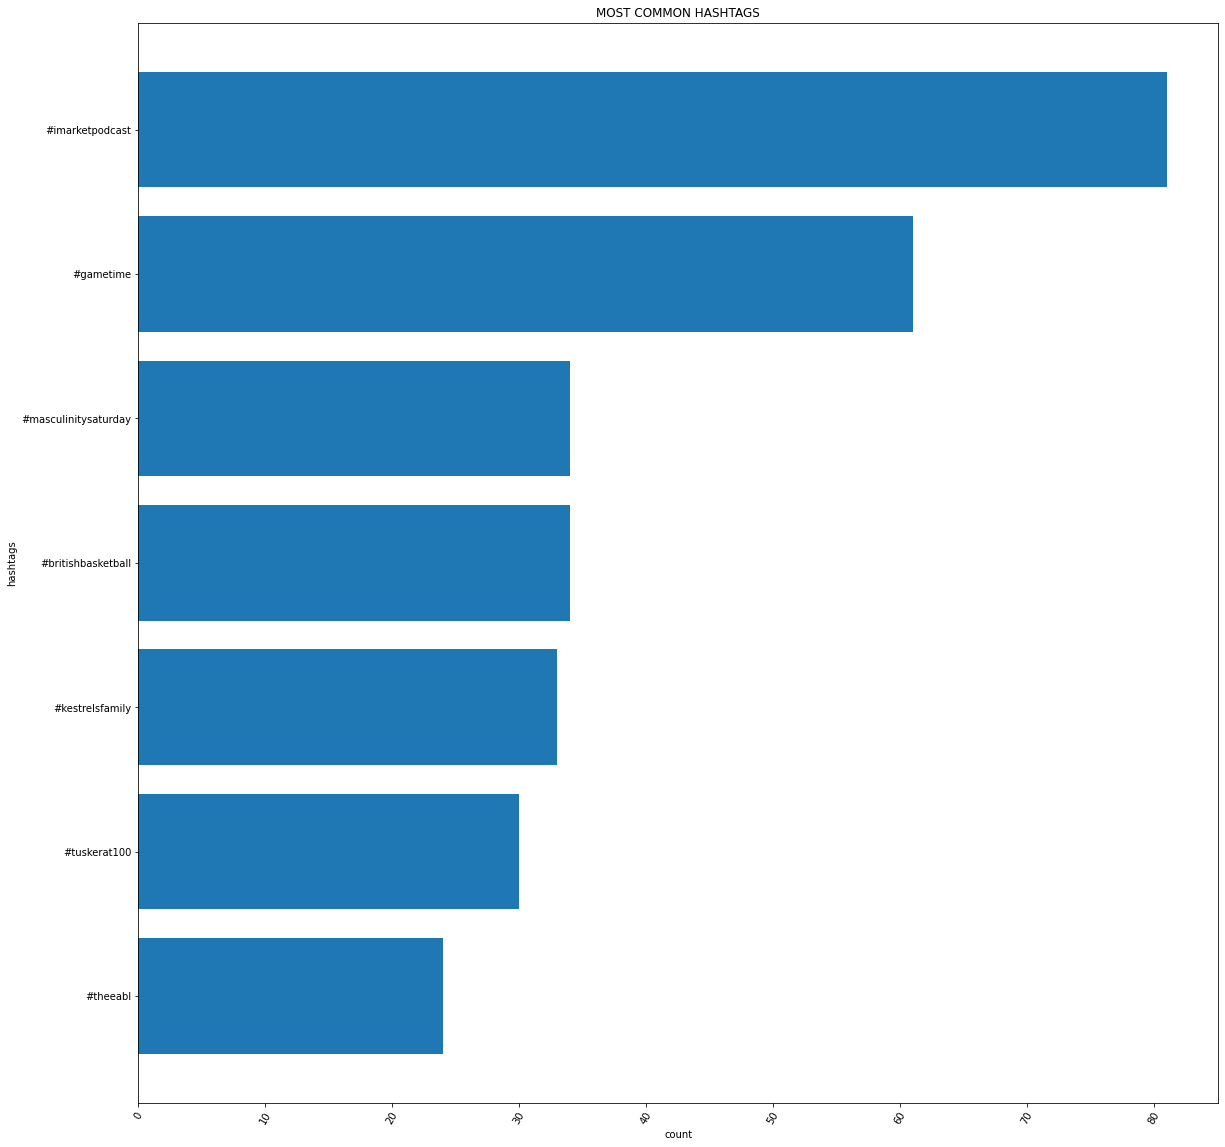

In [ ]:
p_hashtags = make_bars(df_clean['hashtags'].to_list(),ENTRIES , F_SIZE, THRESHOLD, ORDER, GRAPHING_COUNT,'count','hashtags', 'MOST COMMON HASHTAGS')

In [ ]:
p_hashtags

,hashtags,count
0,#imarketpodcast,81
1,#gametime,61
2,#britishbasketball,34
3,#masculinitysaturday,34
4,#kestrelsfamily,33
5,#tuskerat100,30
6,#theeabl,24


### Mentions

In [ ]:
# Visualizing @s on a wordcloud
#
a_df = df_clean['ats'].apply(lambda f : ' '.join(f))

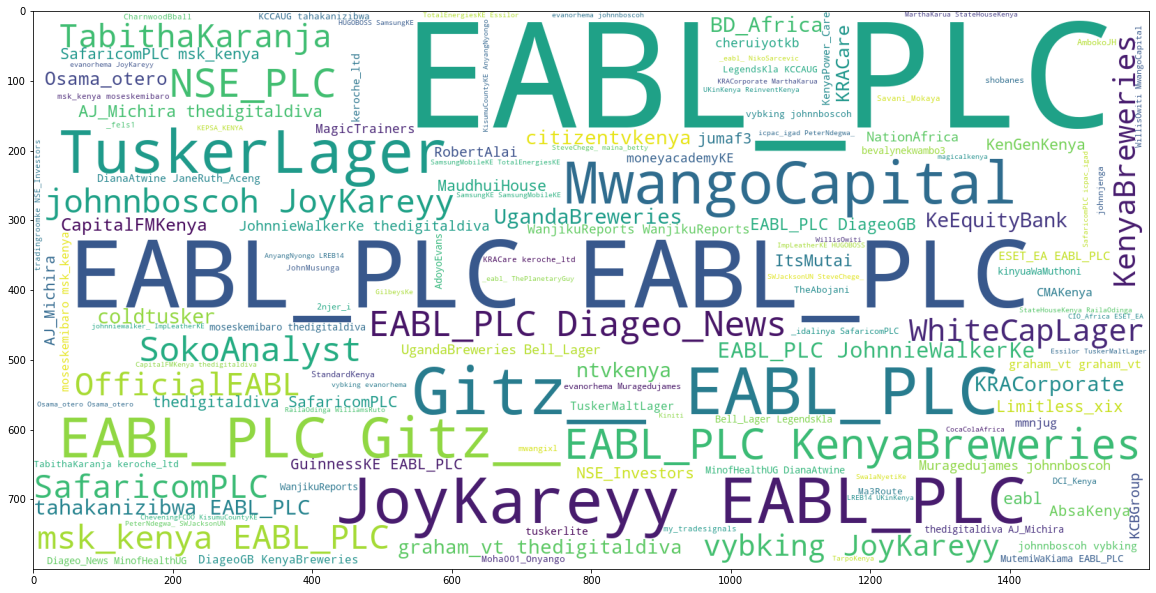

In [ ]:
# Word cloud 
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="white").generate(" ".join(a_df))
plt.imshow(wc2)


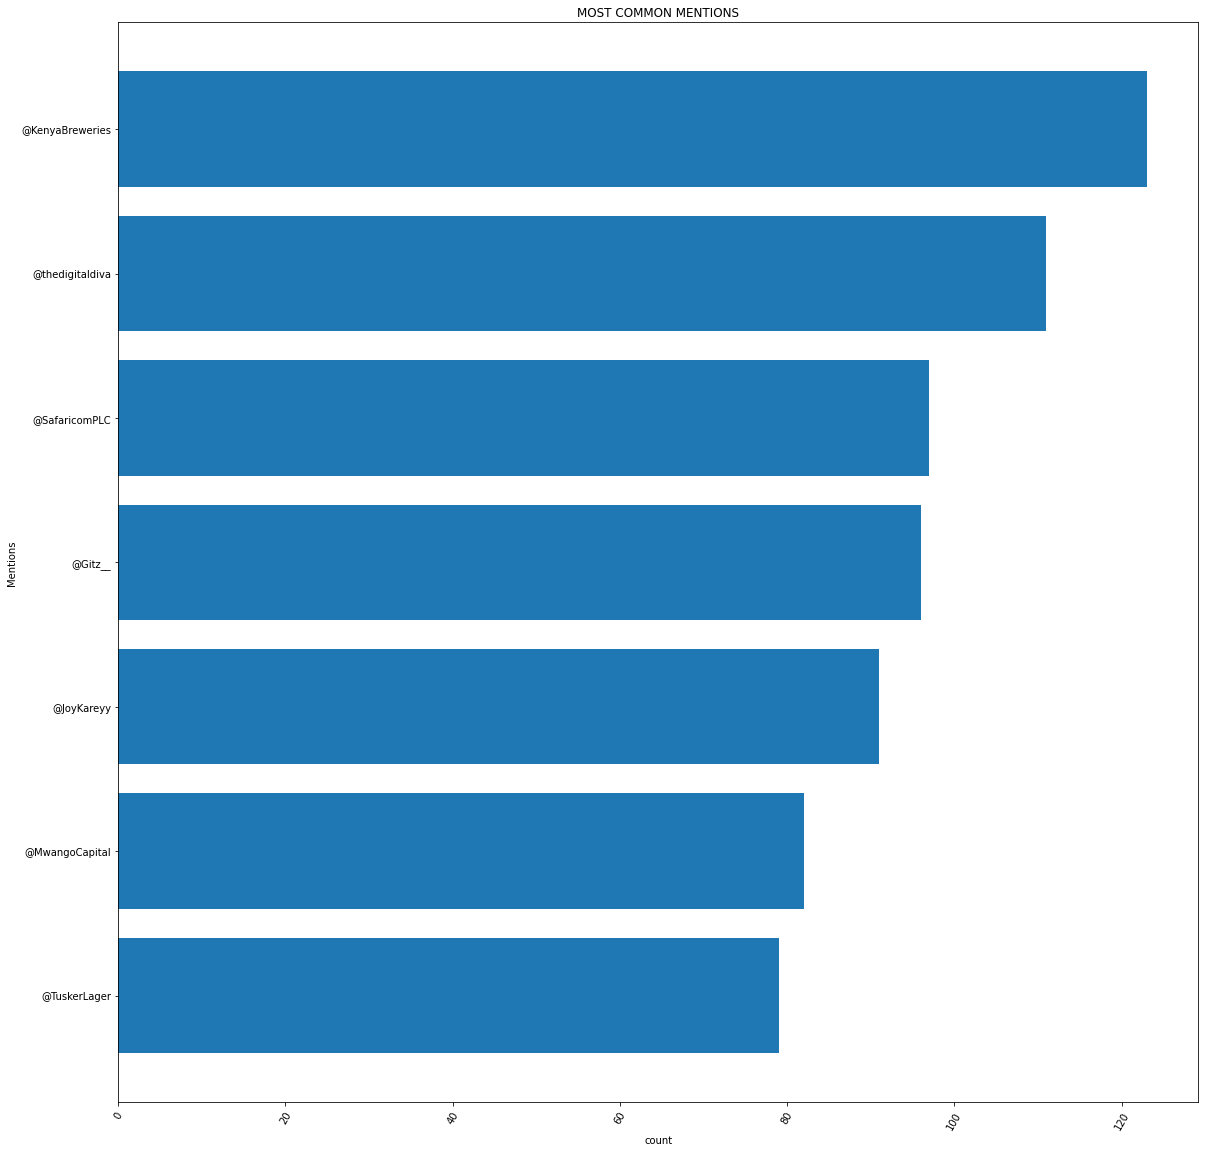

In [ ]:
# A visualization of most @s
#
p_ats = make_bars(df_clean['ats'].to_list(), ENTRIES , F_SIZE, THRESHOLD, ORDER, GRAPHING_COUNT,"count","Mentions", 'MOST COMMON MENTIONS')

In [ ]:
p_ats

,Mentions,count
0,@KenyaBreweries,123
1,@thedigitaldiva,111
2,@SafaricomPLC,97
3,@Gitz__,96
4,@JoyKareyy,91
5,@MwangoCapital,82
6,@TuskerLager,79


### Most Common words in tweet

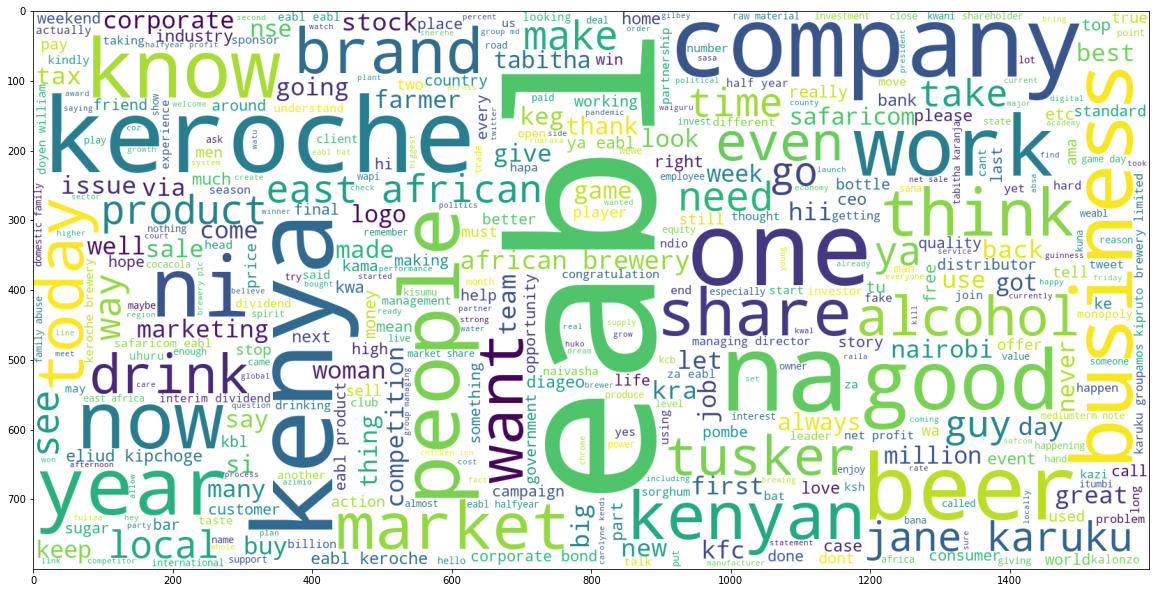

In [ ]:
w_df = df_clean['m_tweet']

# Plotting most common words in a WordCloud
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="white").generate(" ".join(w_df))
plt.imshow(wc2)

In [ ]:
# splitting the m_tweet to individual words

w_df = df_clean['m_tweet'].apply(lambda a : a.split()).to_list()


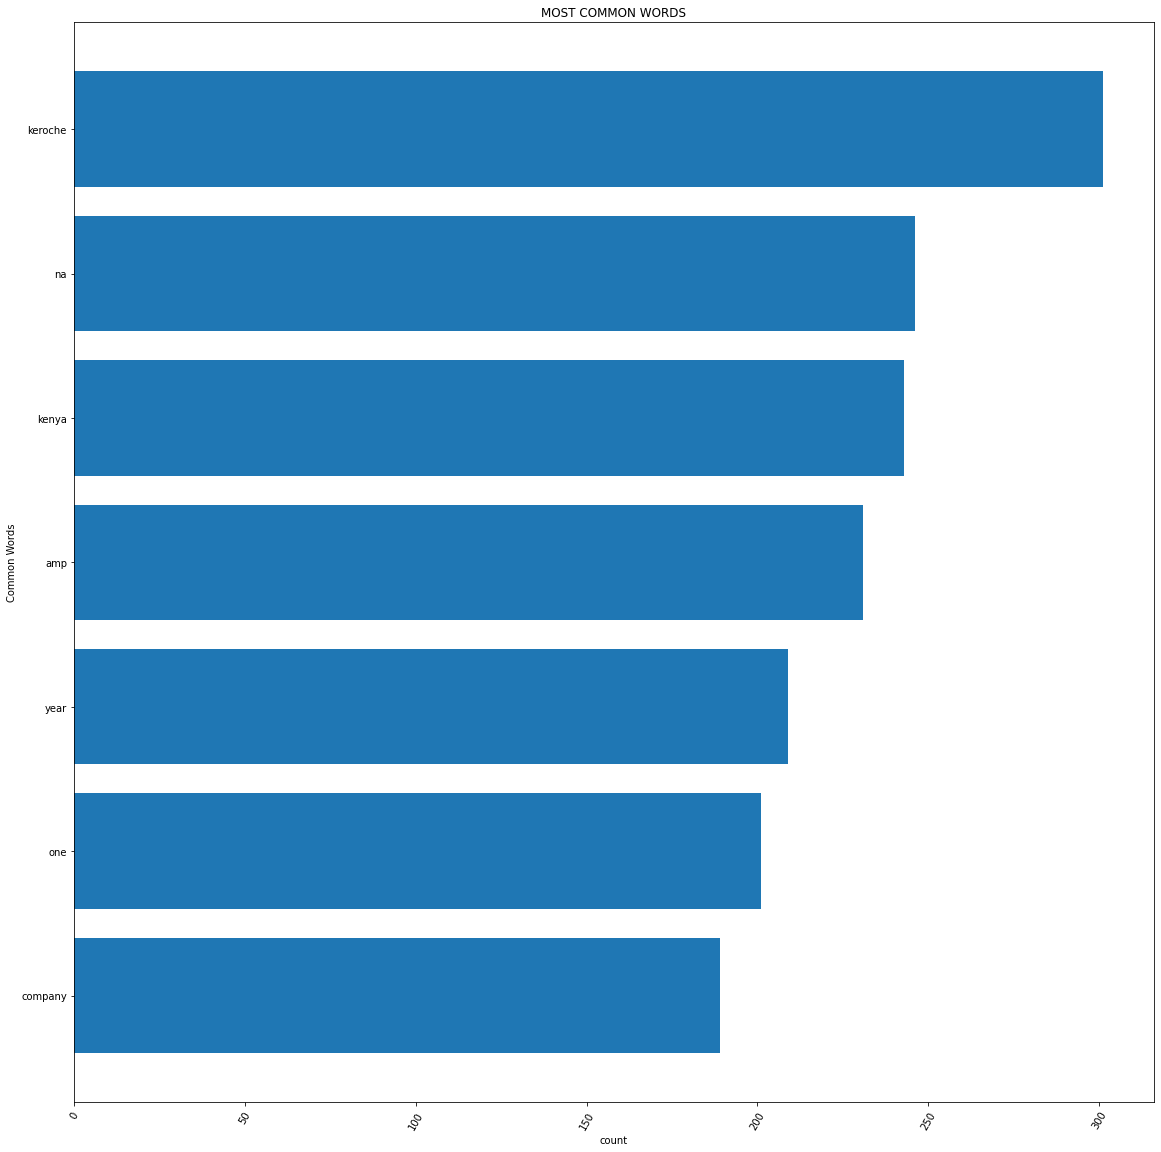

In [ ]:
# Visualizing most common words in a bar plot
#make_bars(df_clean['ats'].to_list(), ENTRIES , F_SIZE, THRESHOLD, ORDER, GRAPHING_COUNT,"count","Mentions")
common_words = make_bars(w_df , ENTRIES , F_SIZE, THRESHOLD, ORDER, GRAPHING_COUNT,"count","Common Words",'MOST COMMON WORDS')

In [ ]:
common_words

,Common Words,count
0,keroche,301
1,na,246
2,kenya,243
3,amp,231
4,year,209
5,one,201
6,company,189


### Pie Chart of Hashtags & Mentions

In [ ]:
df_clean['pie'] = df_clean.apply(lambda r : for_pie(r['hashtags'], r['ats']) , axis = 1)

# Checking to see the key and value of each assigned number ie 0, 1, 2, 3

pie = collections.Counter(df_clean['pie'].to_list())
pie

Counter({0: 944, 1: 2641, 2: 460, 3: 594})

In [ ]:
# Getting the values 
pie.values()

dict_values([2641, 460, 944, 594])

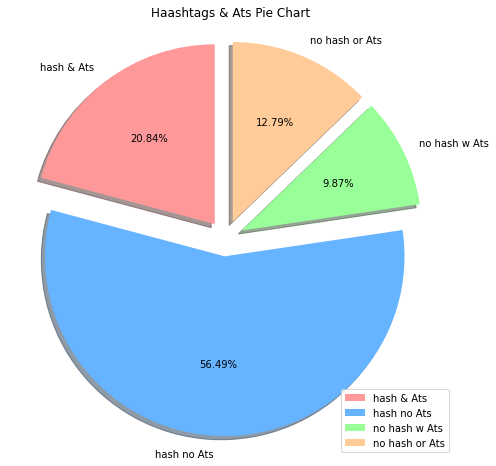

In [ ]:
# Visualizing hastags and ats in a pie chart
#
labels= ['hash & Ats', 'hash no Ats', 'no hash w Ats', 'no hash or Ats']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

sizes= [984, 2667, 466, 604]

plt.figure(figsize =(8, 8))
plt.pie(sizes,labels=labels, colors=colors, startangle=90, shadow=True,explode=(0.1, 0.1, 0.1, 0.1), autopct='%1.2f%%')

plt.title('Haashtags & Ats Pie Chart')

plt.axis('equal')
plt.legend(loc="lower right")
plt.show()

### Word Count

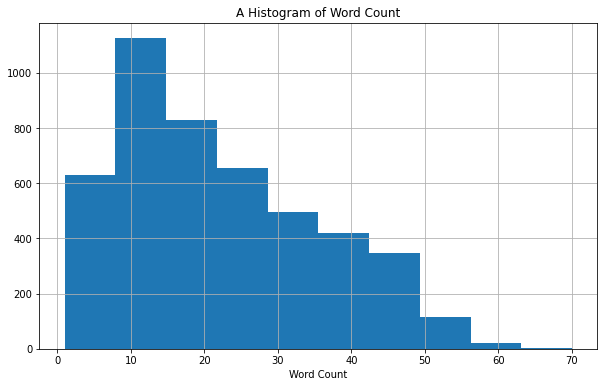

In [ ]:
# A histigrom of no of words 
#
plt.figure(figsize =(10, 6))
df_clean['no_of_words'].hist()
plt.title("A Histogram of Word Count")
plt.xlabel("Word Count")
plt.show();

### Length of Tweet

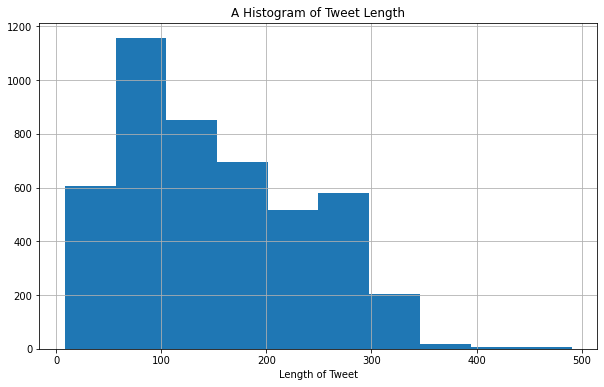

In [ ]:
# A histogram to show distribution of tweet length
#
plt.figure(figsize =(10, 6))
df_clean['length_of_tweet'].hist()
plt.title("A Histogram of Tweet Length")
plt.xlabel("Length of Tweet")
plt.show();


## Sentiment Analysis

In [ ]:
# Polarity

df_clean['polarity'] = df_clean['nr_tweet'].apply(lambda x :get_polarity(x))
df_clean[['nr_tweet', 'polarity']].sample(10)

,nr_tweet,polarity
3159,@thedigitaldiva @SafaricomPLC @msk_kenya @EABL...,0.000000
1390,"""A single day is not really enough to celebrat...",-0.023810
83,@TuskerLager @EABL_PLC The #tuskernexters was ...,0.400000
2203,It spent Sh6.04 billion in 2020 on electricity...,-0.051786
776,@Hey__Z Tafuta a good agency especially zile z...,0.350000
3626,@EABL_PLC next time our boys are going to sell...,0.250000
738,"Since then, the brand has evolved and still st...",0.433333
2504,EABL HALF-year to December net profit more tha...,0.250000
4930,@T_Gathoni That's cheap compared to the madnes...,0.400000
4860,You are cordially invited to the Inaugural @S...,0.000000


In [ ]:
# Subjectivity

df_clean['subjectivity'] = df_clean.tweet.apply(get_subjectivity)
df_clean[['tweet', 'subjectivity']].sample(10)

,tweet,subjectivity
1291,"@mburu2020 @Keerulanah Explain?, Or does EABL ...",0.000000
4,@saitot_i @EABL_PLC Tell them about me,0.000000
628,Client : Eabl\n\nCampaign : Raise the bar\n\nT...,0.000000
4576,@NSE_PLC has started trading @EABL_PLC Ksh11 b...,0.000000
2001,@Gitz__ @EABL_PLC building relatable brands,0.000000
3779,@JaneMarriottUK @EABL_PLC @CheveningFCDO @Kisu...,0.491667
3583,@ThisIsAllexie @ntvkenya U only saw EABL in th...,0.706667
4715,"3/3-Thread\n#UBLat75\nToday, @PilsnerLagerUg i...",0.333333
3063,@Switchkenya @Osama_otero They do use local ra...,0.230769
4041,Centre Josh Ijeh of James Watt College-BMet we...,0.066667


In [ ]:
# Extracting sentiments score
#
df_clean['sentiment_score'] = df_clean['tweet'].apply(lambda x: TextBlob(x).sentiment[0])
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score']].sample(10)


,tweet,polarity,subjectivity,sentiment_score
3125,@TyJustin_ @MbuguaKim2 @kalromkulima Ask EABL.,0.000000,0.000000,0.000000
1679,@nandiThembi @254Hooch @Osama_otero @EABL_PLC ...,0.000000,0.000000,0.000000
1084,Love is for the birds https://t.co/2WYbct4I1I...,0.500000,0.600000,0.500000
2972,@EABL_PLC was enquiry channel to follow to app...,0.200000,0.100000,0.200000
4811,@JumiaKenya Jumia Black Friday this year Gold ...,-0.166667,0.433333,-0.166667
3428,@WanjikuReports @EABL_PLC as an intern,0.000000,0.000000,0.000000
3851,Nunua makali kwa lorry za yellow (Distributors...,0.000000,0.000000,0.000000
3673,@KenyaBreweries @EABL_PLC Support local rehabs.,0.000000,0.000000,0.000000
500,EABL rolls out domestic and family abuse guide...,0.000000,0.100000,0.000000
1284,Kibaki Grandson And Betty Kyallo Little Sister...,0.056250,0.350000,0.056250


In [ ]:
# Labelling sentiments to either Positive or Negative
#

df_clean['sentiment'] = df_clean.apply(lambda r : positive_negative_b(r['sentiment_score']) , axis = 1)
df_clean['sentiment_nb'] = df_clean.apply(lambda r : positive_negative(r['sentiment_score']) , axis = 1)
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score', 'sentiment']].sample(10)


,tweet,polarity,subjectivity,sentiment_score,sentiment
2146,This is the 7th case of rape/ sexual assault o...,0.300000,0.650000,0.300000,Positive
748,@EABL_PLC came up with #KBLStillGotSkillz comp...,0.000000,0.000000,0.000000,Positive
4402,ICYMI: Uhuru takes time off COP26 to visit Joh...,0.000000,0.000000,0.000000,Positive
3321,@vickykoech_ And it's not just farmers. Think ...,0.102778,0.647222,0.102778,Positive
2712,Client : Eabl\nCampaign : Flow na Chrome \nTea...,0.000000,0.000000,0.000000,Positive
1017,@uncharterdxylem Kindly give us your opinion o...,0.600000,0.900000,0.600000,Positive
4783,"EABL raises Sh37.9 billion for expansion, repa...",0.000000,0.000000,0.000000,Positive
3774,@_goraoro 😭eabl si wafix offers huko ndani?,0.100000,0.000000,0.100000,Positive
4260,@MaoistRebelNews @slavojvibecheck As a monothe...,0.250000,0.983333,0.250000,Positive
4418,When i chose Islam 8 years ago i knew it would...,0.100000,0.250000,0.100000,Positive


### Scatter plot of Polarity & Subjectivity

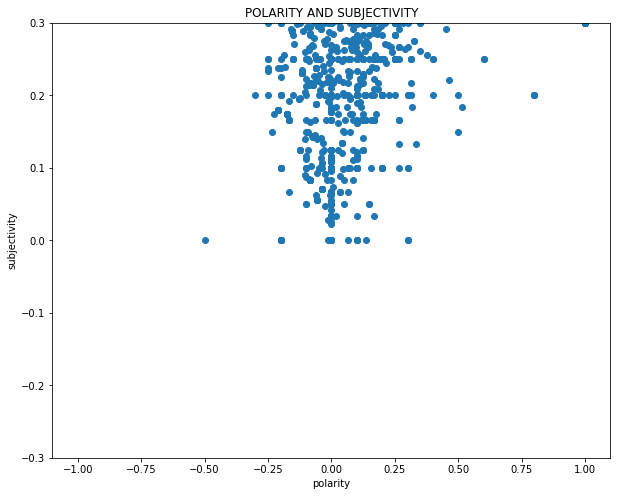

In [ ]:
# plotting the line-chart for the average polarity with the supply-chain-incidents
plt.figure(figsize =(10, 8))
plt.title("POLARITY AND SUBJECTIVITY")
plt.xlabel("polarity")
plt.ylabel("subjectivity")
plt.ylim(-0.3, 0.3)
plt.scatter(df_clean['polarity'],	df_clean['subjectivity'])
plt.show();


### Frequency distribution of sentiment analysis

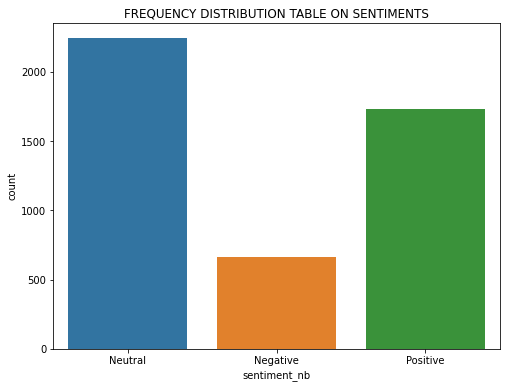

In [ ]:
# a plot of sentiments 
#
import seaborn as sns

plt.figure(figsize =(8, 6))
sns.countplot(data=df_clean, x= 'sentiment_nb') 
plt.title("FREQUENCY DISTRIBUTION TABLE ON SENTIMENTS")
plt.show();


In [ ]:
# Frequency distributions of the sentiment categories
#
df_clean[['m_tweet', 'sentiment']].groupby('sentiment').describe()

m_tweet                                                            \
            count unique                                                top   
sentiment                                                                     
Negative      664    664  please ask israel hr give u feedback father la...   
Positive     3975   3975  eabl hizo mitungi si mzidrop na convoy flani y...   

                
          freq  
sentiment       
Negative     1  
Positive     1

# DECLARATION OF SENTIMENT

In [ ]:
# build our model with the Sequence Classifier and our tokenizer with BERT’s Tokenizer.
#
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Looking at the summary of our model
#
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Getting the dataset
#
dataset = df_clean.copy()
dataset['sentiment']

0       Positive
1       Negative
2       Positive
3       Positive
4       Positive
          ...   
4995    Positive
4997    Negative
4998    Positive
4999    Negative
5000    Positive
Name: sentiment, Length: 4639, dtype: object

In [ ]:
# Creating instance of labelencoder
#

labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
dataset['sentiment_Cat'] = labelencoder.fit_transform(dataset['sentiment'])
dataset.head()

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,...,no_of_words_no_at_hash,length_of_tweet,is_there_digit,pie,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,sentiment_Cat
0,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@CNairobian1 EABL hizo mitungi si mzidrop off ...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,[],[@CNairobian1],eabl hizo mitungi si mzidrop na convoy flani y...,eabl hizo mitungi si mzidrop na convoy flani y...,@cnairobian1 eabl hizo mitungi si mzidrop na c...,3,1,...,11,75,0,1,0.0000,0.000000,0.0000,Positive,Neutral,1
1,@EABL_PLC Once again please ask Israel in hr t...,@EABL_PLC Once again please ask Israel in hr t...,@eabl_plc please ask israel hr give u feedback...,[],[@EABL_PLC],please ask israel hr give u feedback father la...,please ask israel hr give u feedback father la...,@eabl_plc please ask israel hr give u feedback...,3,1,...,15,94,0,1,-0.0625,0.220833,-0.0625,Negative,Negative,0
2,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@Amaragibs @OleItumbi Hio cover Iko Kwa meza n...,@amaragibs @oleitumbi hio cover iko kwa meza n...,[],"[@Amaragibs, @OleItumbi]",hio cover iko kwa meza ni zile za keg hupeanwa...,hio cover iko kwa meza ni zile za keg hupeanwa...,@amaragibs @oleitumbi hio cover iko kwa meza n...,3,2,...,10,77,0,1,0.0000,0.000000,0.0000,Positive,Neutral,1
3,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @Kenyans I rember him from the EABL fi...,@mmnjug @kenyans rember eabl fiasco,[],"[@mmnjug, @Kenyans]",rember eabl fiasco,rember eabl fiasco,@mmnjug @kenyans rember eabl fiasco,5,2,...,6,53,0,1,0.0000,0.000000,0.0000,Positive,Neutral,1
4,@saitot_i @EABL_PLC Tell them about me,@saitot_i @EABL_PLC Tell them about me,@saitot_i @eabl_plc tell,[],"[@saitot_i, @EABL_PLC]",tell,tell,@saitot_i @eabl_plc tell,2,2,...,2,38,0,1,0.0000,0.000000,0.0000,Positive,Neutral,1


In [ ]:
dataset.to_csv('after_bert.csv', index = False)

# MODELLING

### Handling of the class Imbalance

In [ ]:
# Performing oversampling to deal with our class imbalance 
# This is because undersampling requires a large number of records which we don't have in our case

# Let's start by seeing the shape of our classes
positive = dataset[dataset['sentiment_Cat']==1]
negative = dataset[dataset['sentiment_Cat']==0]

print(positive.shape,negative.shape)

(3975, 24) (664, 24)


In [ ]:
# Splitting our dataset into dependent and independent variables

X = dataset['m_tweet'].values.reshape(-1, 1)
y = dataset['sentiment_Cat'].values.reshape(-1, 1)

print(X.shape, y.shape)

(4639, 1) (4639, 1)


In [ ]:
# Performing oversampling
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(sampling_strategy=0.5)
X_res, y_res = os.fit_resample(X,y)

In [ ]:
# The new shape of our X and y variables
print(X_res.shape,y_res.shape)

(5962, 1) (5962,)


In [ ]:
# Checking for the imbalance of the sentiment columns

dataset['sentiment_Cat'].value_counts()

1    3975
0     664
Name: sentiment_Cat, dtype: int64

In [ ]:
# Checking to see that we corrected the imbalance

np.unique(y_res, return_counts=True)

(array([0, 1]), array([1987, 3975]))

In [ ]:
# Splitting
#
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
# Having a preview of four random tweets
X_train

array([['kpl inafaa ichanue wasee juu ya local games leo pale game ya mathare v vihiga entrance ilikua tu 100 bob news leteni kazi ni market httpstco8r31dmr7ef'],
       ['eabl resume dividend profit doublesa growth value investing dividend stock'],
       ['plus experience whole better here ableabl academy offer basketball hour university do disappointing'],
       ...,
       ['wanikujie juu ya ive license distributor ni kwal eabl london distiller directly si ati theyll say im selling fake liquor know cover myself'],
       ['local raw material sourcing spare eabl russia shocks httpstconu7fgwk0xk httpstcotfoyfsdpyu'],
       ['kra serous come 2007 date issue come reclassification affected keroche yet eabl never complained change keroche make almost brand them much realized eabl side']],
      dtype=object)

## Implementation of Deep Learning Models

### BERT

In [ ]:
# Importing the BERT model and get embeding vectors for few sample statements
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4, Total size: 429.66MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.


In [ ]:
# Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding([
    "bread", 
    "grapes",
    "mango",
    "Jasmine Wakini",
    "Ruth Nguli",
    "Billiah Kerubo"
]
)

In [ ]:
cosine_similarity([e[0]],[e[1]])

array([[0.9748135]], dtype=float32)

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.85866576]], dtype=float32)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
# The summary of our BERT model:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
# Length of X_train and X_test
print(len(X_train))
print(len(X_test))

4769
1193


In [ ]:
# Obtaining the metrics needed for our assessment
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
# Training the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
150/150 [==============================] - 110s 656ms/step - loss: 0.6334 - accuracy: 0.6618 - precision: 0.6719 - recall: 0.9639
Epoch 2/10
150/150 [==============================] - 100s 664ms/step - loss: 0.6126 - accuracy: 0.6599 - precision: 0.6819 - recall: 0.9189
Epoch 3/10
150/150 [==============================] - 99s 661ms/step - loss: 0.6062 - accuracy: 0.6666 - precision: 0.6863 - recall: 0.9214
Epoch 4/10
150/150 [==============================] - 99s 661ms/step - loss: 0.5993 - accuracy: 0.6716 - precision: 0.6967 - recall: 0.8994
Epoch 5/10
150/150 [==============================] - 99s 661ms/step - loss: 0.6002 - accuracy: 0.6760 - precision: 0.6990 - recall: 0.9035
Epoch 6/10
150/150 [==============================] - 99s 661ms/step - loss: 0.5877 - accuracy: 0.6819 - precision: 0.7012 - recall: 0.9117
Epoch 7/10
150/150 [==============================] - 99s 660ms/step - loss: 0.5867 - accuracy: 0.6779 - precision: 0.7023 - recall: 0.8979
Epoch 8/10
150/150

In [ ]:
# Model evaluation
model.evaluate(X_test, y_test)

38/38 [==============================] - 26s 648ms/step - loss: 0.5712 - accuracy: 0.7066 - precision: 0.7384 - recall: 0.8651


[0.571201503276825, 0.7066219449043274, 0.7384284138679504, 0.8650693297386169]

In [ ]:
# Prediction
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, ..., 1, 1, 1])

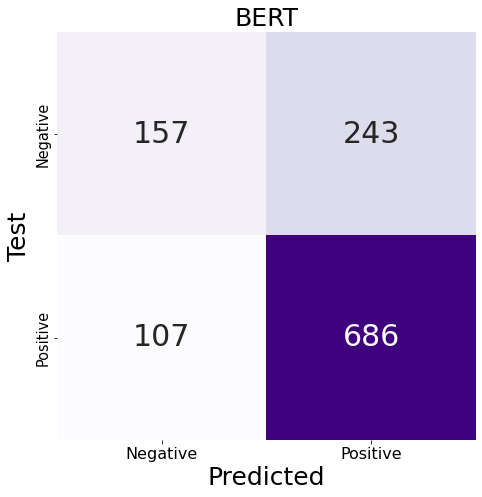

In [ ]:
conf_matrix (y_test, y_predicted, 'BERT' , ['Negative', 'Positive'])

In [ ]:
# Classification report
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.59      0.39      0.47       400
           1       0.74      0.87      0.80       793

    accuracy                           0.71      1193
   macro avg       0.67      0.63      0.63      1193
weighted avg       0.69      0.71      0.69      1193



In [ ]:
# Inference
sentiments = [
    "april kengen dividend may equity dividend june dtb dividend december eabl dividend etc etc 30 company giving dividend 12 months roughly 2 company give dividend per month", 
    "congratulations randolph worthy battle well fought"]
model.predict(sentiments)

array([[0.48523888],
       [0.74254924]], dtype=float32)

### Challenging the Solution

In [ ]:
#from sklearn.feature_extraction.text import Tfid

In [ ]:
# Training the Model
# Now that we have performed feature extraction from our data, it is time to build our model. 
# We will start by splitting our data into training and test sets
# 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts_cv.toarray(), dataset['sentiment_Cat'], test_size=0.1, random_state=69)

In [ ]:
# Printing splitted dataset sizes
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (4175, 56032)
X_test_shape :  (464, 56032)
y_train_shape :  (4175,)
y_test_shape :  (464,)


In [ ]:
training_data = X_train
testing_data = X_test

In [ ]:
param_grid = {
    'n_estimators': [50,150],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

clf_rf = RandomForestClassifier()

param_tuning(clf_rf, param_grid, training_data, y_train, testing_data, y_test)

In [ ]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=42)
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)
nb = MultinomialNB()
mlp = MLPClassifier(random_state=42)

clfs = {
    "Random Forest": rf,
    "Gradient Boosting":gb,
    "AdaBoost": ada,
    "LightGBM": lgb,
    "XGBoost": xgb,
    "Decision Tree":dt,
    "Support Vector Machine":svc,
    "Naive Bayes": nb,
    "Multilayer Perceptron":mlp
}

accuracys = []
model_name = []
f1 = []
pre = []
rec = []


for name,clf in clfs.items():
    curr_acc = fit_model(clf,training_data,y_train,testing_data,y_test, name)
    model_name.append(name)
    accuracys.append(curr_acc[0])
    f1.append(curr_acc[0])
    pre.append(curr_acc[0])
    rec.append(curr_acc[0])
    #print(name)
    #precisions.append(curr_pre)

In [ ]:
models_df = pd.DataFrame({"Models":model_name,"Accuracy Scores":accuracys, 'F1_Scores':f1 , 'Precision':pre , 'Recall':rec}).sort_values('F1_Scores',ascending=False)
models_df

In [ ]:
models_df.describe().loc[['min', 'max'], :]

# CONCLUSION

Twitter can be an effective tool used to market, launch and monitor the progress of a new product.

Twitter hashtags attract thousands of individuals making it a good area to market businesses. 


# RECOMMENDATION

We would recommend the investor to go for the company (EABL) when investing as the company shows great potential as seen in the massive number of positive sentiments.

 We would recommend for the organization (EABL) to use more of the commonly used # and @ those are #imarketpodcast and @KenyaBreweries respectively to raise more traffic on the company’s page.

Structured small catchy tweets are likely to communicate more effectively and receive reactions from numerous individuals.

A brand should investigate on the right wording of their tweet.

Partnering with major influencers such as radio stations  would improve the chances of consumers reading information on an event promoting the product.
